# Train neural network model

## Hyper-parameters and placeholders

In [1]:
import tensorflow as tf
import numpy as np
from CNN import get_cnn
import os
import time
import datetime
import pickle
import csv

K = 400 # word2vec embedding dimension
L = 50 # 50 words limit for each sentence
NUM_CLASSES = 2

_x = tf.placeholder(tf.float32, [None, L, K], name='input_x')
_y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='input_y')



In [11]:
import gensim

MODEL_PATH = 'dataset/word2vec_twitter_model.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=3000000)
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=300000)
print('W2V loaded!')

c:\users\yanpe\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


W2V loaded!


## Load and preprocess training dataset

In [12]:
''' load training dataset '''
TRAIN_SET_NAME = 'train_set_original'
TRAIN_DATA_PATH = 'dataset/'+TRAIN_SET_NAME+'.csv'
TWEETS_LIST = []
LABEL_LIST = []
with open(TRAIN_DATA_PATH, newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        TWEETS_LIST.append(row[2]) # the third row is the original text
        #TWEETS_LIST.append(row[1]) # the second row is the modified text
        
        if row[3] == '0':
            ''' Negative '''
            LABEL_LIST.append([1,0])
        else:
            ''' Positive '''
            LABEL_LIST.append([0,1])
print('Training dataset loaded')
print('Number of tweets in training dataset: ',len(TWEETS_LIST))

''' load lookup table '''
with (open('dataset/'+TRAIN_SET_NAME+'.lookup', 'rb')) as openfile:
    try:
        LOADED_TABLE = pickle.load(openfile)
        print('Lookup table loaded')
    except EOFError:
        print('ERROR!')
        
''' preprocess data '''
x_train = []
for tweet in TWEETS_LIST:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word])
        except:
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_train.append(np.array(tmp))
x_train = np.array(x_train)
y_train = np.array(LABEL_LIST)

''' Random shuffle the data '''
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(x_train)))
x_train = x_train[shuffle_indices]
y_train = y_train[shuffle_indices]

print('Data Preprocessed!')

Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!


## Load and preprocess testing dataset

In [13]:
''' load training dataset '''
TEST_DATA_PATH = 'dataset/test_set-actual-pure.csv'
TWEETS_LIST = []
LABEL_LIST = []
with open(TEST_DATA_PATH, newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        TWEETS_LIST.append(row[2]) # the third row is the original text
        #TWEETS_LIST.append(row[1]) # the second row is the modified text

        if row[3] == '0':
            ''' Negative '''
            LABEL_LIST.append([1,0])
        else:
            ''' Positive '''
            LABEL_LIST.append([0,1])
print('Training dataset loaded')
print('Number of tweets in training dataset: ',len(TWEETS_LIST))

''' preprocess data '''
x_test = []
for tweet in TWEETS_LIST:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word])
        except:
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_test.append(np.array(tmp))
x_test = np.array(x_test)
y_test = np.array(LABEL_LIST)

''' Random shuffle the data '''
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(x_test)))
x_test = x_test[shuffle_indices]
y_test = y_test[shuffle_indices]

print('Data Preprocessed!')

Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!


## Visualize the 2D tweet

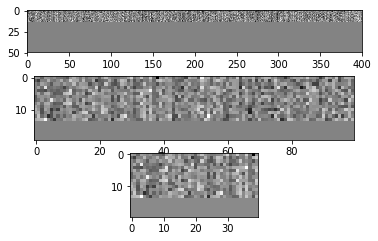

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

sample = x_train[0].reshape(L,K)
plt.subplot('311')
plt.imshow(sample, cmap=plt.get_cmap('gray'))
plt.subplot('312')
plt.imshow(sample[:20,:100], cmap=plt.get_cmap('gray'))
plt.subplot('313')
plt.imshow(sample[:20,:40], cmap=plt.get_cmap('gray'))

## Load CNN model

In [6]:
POS_WEIGHT = 372.0/2700
#POS_WEIGHT = 5352.0/12661

scores, predictions, loss, accuracy = get_cnn(_x, _y, POS_WEIGHT) 
print('CNN created')

CNN created


## Train

In [36]:
PRINT_STEP = 100
LR = 1e-3 # learning rate
TOTAL_EPOCHS = 17
BATCH_SIZE = 64

''' Optimizer '''
global_step = tf.Variable(0, name="global_step", trainable=False)
optimizer = tf.train.AdamOptimizer(LR)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

with tf.Session() as sess:
    # Initialize parameters
    sess.run(tf.global_variables_initializer())
    
    # Saver
    saver = tf.train.Saver()
    
    step = 0
    # Train epochs
    for epoch in range(TOTAL_EPOCHS):
        
        i = 0
        while True:
            ''' Get training batch '''
            if i+BATCH_SIZE > len(x_train):
                break
            else:
                batch_x = x_train[i:i+BATCH_SIZE]
                batch_y = y_train[i:i+BATCH_SIZE]
                i += BATCH_SIZE
            
            ''' Train the model '''
            sess.run(train_op, feed_dict={_x: batch_x, _y: batch_y})
            
            ''' Display '''
            if step%PRINT_STEP == 0:
                [train_acc, train_loss] = sess.run([accuracy, loss], feed_dict={_x: batch_x, _y: batch_y})
                [test_acc, test_loss] = sess.run([accuracy, loss], feed_dict={_x: x_test, _y: y_test})
                print('Step: '+str(step)+' Train_Acc: '+str(train_acc)+' Train_loss: '+str(train_loss)+' Test_Acc: '+str(test_acc)+' Test_loss: '+str(test_loss))
                #print(str(step)+','+str(train_acc)+','+str(train_loss)+','+str(test_acc)+','+str(test_loss))
            
            step+=1
            
        ''' Epoch test '''
        [test_acc, test_loss] = sess.run([accuracy, loss], feed_dict={_x: x_test, _y: y_test})
        print('\nEpoch: '+str(epoch)+' Test_Acc: '+str(test_acc)+' Test_loss: '+str(test_loss))
        print('Epoch ', epoch)
        ''' Save model '''
        saver.save(sess, 'saved_model-2700/model.ckpt')
        #print('Model saved\n')
        
        

Step: 0 Train_Acc: 0.921875 Train_loss: 0.15228921 Test_Acc: 0.48846152 Test_loss: 0.69495547

Epoch: 0 Test_Acc: 0.57884616 Test_loss: 0.38801152
Epoch  0

Epoch: 1 Test_Acc: 0.61730766 Test_loss: 0.31000826
Epoch  1
Step: 100 Train_Acc: 0.96875 Train_loss: 0.0406278 Test_Acc: 0.71057695 Test_loss: 0.19600672

Epoch: 2 Test_Acc: 0.6701923 Test_loss: 0.24779177
Epoch  2

Epoch: 3 Test_Acc: 0.64326924 Test_loss: 0.35408884
Epoch  3
Step: 200 Train_Acc: 0.984375 Train_loss: 0.014189629 Test_Acc: 0.6625 Test_loss: 0.32386932

Epoch: 4 Test_Acc: 0.6096154 Test_loss: 0.43967244
Epoch  4

Epoch: 5 Test_Acc: 0.63461536 Test_loss: 0.39459336
Epoch  5

Epoch: 6 Test_Acc: 0.6557692 Test_loss: 0.3746913
Epoch  6
Step: 300 Train_Acc: 1.0 Train_loss: 0.011902002 Test_Acc: 0.6057692 Test_loss: 0.5359035

Epoch: 7 Test_Acc: 0.6576923 Test_loss: 0.38020328
Epoch  7

Epoch: 8 Test_Acc: 0.67115384 Test_loss: 0.37602827
Epoch  8
Step: 400 Train_Acc: 0.984375 Train_loss: 0.011199832 Test_Acc: 0.74615383 T

## Demo

In [7]:
import gensim
MODEL_PATH = 'dataset/word2vec_twitter_model.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=300000)

c:\users\yanpe\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:

input_texts = [
    'cocaine snorting day',
    'vape lot bud err day',
    'gonna injest a tabs get real',
    'inhale nitrous stay up enjoy',
    'shoot up that real smack enjoy',
    'like LSD seeing the colour',
    'heroin blaze it all time',
    'injesting toking doping xanax',
    'chewing shrooms kind day',
    'make mary jane enjoy pot smoke'
    'i enjoy smoking weed',
    'the government should legalize crack and meth',
    'snorting cocaine is a good time',
    'smoke weed everyday',
    'there is a man by the arcade selling sweetest dope',
    'i should switch to crack and become the largest of the crack heads',
    'smoking a blunt and keeping it real',
    '420 blaze it with some sweet bud',
    'the world would be better if we all smoked weed and did LSD',
    'thinking about moving up to something more powerful perhaps crack or coke',
    '=========',
    'i think all drugs should be illegal',
    'the chimney is smoking and I mowed the grass',
    'the opioid crisis has gotten out of control',
    'my mom says cocaine and pills lead to failure',
    'i have never done drugs especially not weed',
    'special k is delicious',
    'i feel like a complete dope',
    'my bud and I are going to board on the sweet powder',
    'the government should do something about all these drugs',
    'people should in fact not smoke weed everyday'
]


x_ = []
for tweet in input_texts:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word])
        except:
            print('Och, the word \"'+word+'\" cannot be found in the w2v model!')
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_.append(np.array(tmp))
x_ = np.array(x_)

print('\ninput shape: ',x_.shape)

with tf.Session() as sess:
    # Load parameters
    saver = tf.train.Saver()
    saver.restore(sess, 'saved_model/model.ckpt')

    pred = sess.run([predictions], feed_dict={_x: x_})

    pred = np.array(pred[0])
    
    ''' Display result '''
    print('\nRESULTS (+: positive; -: negative):')
    for i in range(len(input_texts)):
        if pred[i] == 1:
            print('+: ',input_texts[i])
        else:
            print('-: ',input_texts[i])

Och, the word "injest" cannot be found in the w2v model!
Och, the word "injesting" cannot be found in the w2v model!
Och, the word "smokei" cannot be found in the w2v model!
Och, the word "420" cannot be found in the w2v model!
Och, the word "=========" cannot be found in the w2v model!

input shape:  (30, 50, 400)
INFO:tensorflow:Restoring parameters from saved_model/model.ckpt

RESULTS (+: positive; -: negative):
+:  cocaine snorting day
+:  vape lot bud err day
+:  gonna injest a tabs get real
+:  inhale nitrous stay up enjoy
-:  shoot up that real smack enjoy
+:  like LSD seeing the colour
+:  heroin blaze it all time
+:  injesting toking doping xanax
+:  chewing shrooms kind day
+:  make mary jane enjoy pot smokei enjoy smoking weed
+:  the government should legalize crack and meth
+:  snorting cocaine is a good time
+:  smoke weed everyday
-:  there is a man by the arcade selling sweetest dope
-:  i should switch to crack and become the largest of the crack heads
-:  smoking a bl

# Testing ROC Curve

In [37]:
with tf.Session() as sess:
    # Load parameters
    saver = tf.train.Saver()
    saver.restore(sess, 'saved_model-2700/model.ckpt')
    [scor, pred, accu] = sess.run([scores, predictions, accuracy], feed_dict={_x: x_test, _y: y_test})
print('Accuracy: ', accu)

def sigmoid(x):
    return 1/(1+np.exp(-x))

positive_scores = np.zeros(len(scor))
for i in range(len(scor)):
    #positive_scores[i] = sigmoid(scor[i][1])
    positive_scores[i] = sigmoid(scor[i][1] - scor[i][0])

from sklearn.metrics import roc_curve, auc

ground_truth = np.zeros(len(y_test), dtype=int)

for i in range(len(y_test)):
    if y_test[i][1] == 1:
        ground_truth[i] = 1
        
fpr, tpr, thresholds = roc_curve(ground_truth, positive_scores)
roc_auc = auc(fpr, tpr)

INFO:tensorflow:Restoring parameters from saved_model-2700/model.ckpt
Accuracy:  0.7605769


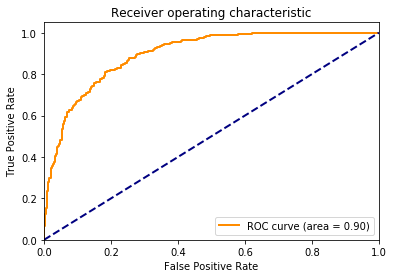

In [38]:
import matplotlib.pyplot as plt
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()